<h1 style="text-align:center; font-size: 3em;">
    Detecting Pneumonia from Chest X-rays
</h1>

---

<h1 style="font-size:1.6em;">Introduction</h1>
<p>Pneumonia is a respitory disease that inflames air sacs in the lungs. These air sacs can fill up with fluid or pus, and this causes patients to cough. Other symptoms include heavy breathing, chills and fever.</p>

<p>To diagnose this illness, doctors look for white spots in the lungs that indicate some sort of fluid. This is a common indication of an infection in the lungs</p>

<p>However even though it may sound simple enough, diagnosing a patient is no easy task. According to the Centers for Disease Control and Prevention (CDC), approximately 1 million people in the U.S. are diagnosed with pneumonia every year. Most of them are adults. More than 50,000 die from the disease.
    
<p style="font-size:10px;">Source: <a href="https://www.diamondinjurylaw.com/blog/2017/11/16/pneumonia-misdiagnosis/">Diamond Injury Law Blog</a></p>

<p>Hence, the purpose of this project (protoype) is to aid doctors and other medical staff in the diagnosis of pneumonia</p> 



---

In [191]:
# -----------------------------------------------------------
# Detecting Pneumonia from Chest X-rays
#
# Data Set: Chest X-Ray Images (Pneumonia) by Paul Mooney @Kaggle.com
# Author: Zafir Khalid
# Email: zafirmk0@gmail.com
# -----------------------------------------------------------

In [218]:
#Importing necessary libraries

#Deep Learning Libraries
from keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,MaxPooling2D
from sklearn.metrics import confusion_matrix, classification_report
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model,Sequential,load_model
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import Adam

#Math Libraries
import numpy as np
import random

#Display Libraries
from IPython.display import display, display_html, SVG
from IPython.core.display import HTML

#Data Visualization Libraries
import matplotlib.pyplot as plt 
import plotly.graph_objs as go
import plotly.offline as pyo
import seaborn as sns

#Misc Libraries (Data management/Image Analysis)
import pandas as pd
import cv2
import os

#Init functions
pyo.init_notebook_mode()
%matplotlib inline

#CSS Styling for jupyter notebook
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

<h1 style="font-size:2em;">Distribution of the Data</h1>
<p>Below we will take a look at bar charts for each of our three types of data. Training, Testing and Validation</p>


<p>As we'll see from the graphs below, the data is highly skewed. With more than 2 times the data being cases of Pneumonia. This in itself is a source of inaccuracy for the training model.</p>

<p>Moreover, the lack of validation data doesn't allow for accurate validation accuracy and validation loss analysis. We will first see how these factors affect our v1 training model and then attempt to create a better model, v2. </p>


---

In [216]:
def display_raw_data(dir, title, rgb_fill, rgb_line):
    """
    Create Bar charts to show data distribution
        
        dir (str): directory of data
        
        title (str): title of bar chart
        
        rgb_fill (str): rgb value of color to fill bars with
        
        rgb_line (str): rgb value of bar outlines
    
    """

    x_labels=["Pneumonia", "Normal"]
    
    #Count number of images in each class present in the directory
    y_heights = [len(os.listdir(dir+"/PNEUMONIA")), len(os.listdir(dir+"/NORMAL"))]
    
    fig = go.Figure([go.Bar(x=x_labels, y=y_heights)])
    
    fig.update_layout(title_text=title)
    
    fig.update_traces(marker_color="rgb" + "(" + str(rgb_fill) + ")", marker_line_color="rgb" + "(" + str(rgb_line) + ")",
                  marker_line_width=1.5, opacity=0.6)
    
    fig.show()

In [217]:
display_raw_data("/Users/zafirkhalid/Desktop/chest_xray/train","Training Data", "158,202,225", "8,48,107")
display_raw_data("/Users/zafirkhalid/Desktop/chest_xray/test", "Testing Data", "158,202,225", "8,48,107")
display_raw_data("/Users/zafirkhalid/Desktop/chest_xray/val", "Validation Data", "158,202,225", "8,48,107")

<h1 style="font-size:2em;">Data Samples</h1>

---

In [203]:
def display_xray(dir):
    """
    Display X-ray images
        
        dir (str): directory of data
    
    """
    
    #Initialize figure, columns and rows
    fig=plt.figure(figsize=(8, 8))
    columns = 2
    rows = 2
    
    for i in range(1, columns*rows +1):
        
        #Select random image from directory and add it to the figure
        img = cv2.imread(dir+os.listdir(dir)[random.randint(0, len(os.listdir(dir)))])
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(i)
    plt.show()

<h1 style="text-align:center;">Normal X-Rays</h1>

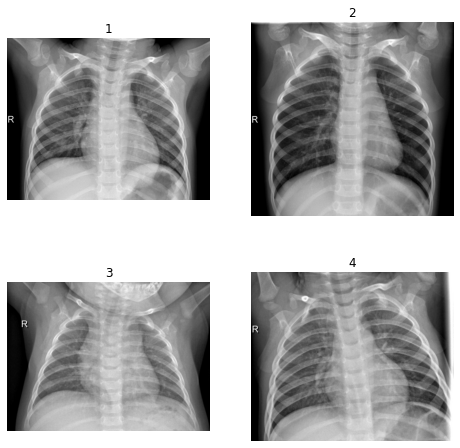

In [204]:
display_xray("/Users/zafirkhalid/Desktop/chest_xray/train/NORMAL/")

<h1 style="text-align:center;">Pneumonia X-Rays</h1>


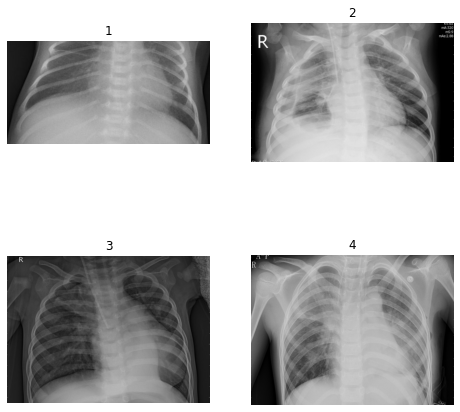

In [205]:
display_xray("/Users/zafirkhalid/Desktop/chest_xray/train/PNEUMONIA/")

<h1 style="font-size:2em;">Data Pre-processing</h1>

<p>Let's begin setting up our data now.</p>

<p>In the cells below the following procedure of data preprocessing is followed:</p>

<ul>
  <li>Initialize DataFrames</li>
    <br>
  <li>Loading in the Data (Images)</li>
    <br>
  <li>Standardizing the Data (Images)</li>
    <br>
  <li>Splitting the data into features(X) and labels(Y)</li>
    <br>
  <li>Augment the Data (Images)</li>
    <br>
  <li>Create training batches</li>
</ul>

---

In [206]:
#Initialize the directories of the train, test and validation images
main_dir = "/Users/zafirkhalid/Desktop/chest_xray"
train_dir = main_dir + "/train"
test_dir = main_dir + "/test"
val_dir = main_dir + "/val"

In [207]:
def mydisplay(dfs, names=[]):
    """
    Function to display pandas data frame row wise
        
        dfs (list): data frames to display
        names (list): Titles to give each data frame
    
    """
    count = 0
    maxTables = 6
    if not names:
        names = [x for x in range(len(dfs))]
    html_str = ''
    html_th = ''
    html_td = ''
    for df, name in zip(dfs, names):
        if count <= (maxTables):
            html_th += (''.join(f'<th style="text-align:center">{name}</th>'))
            html_td += (''.join(f'<td style="vertical-align:top"> {df.to_html(index=False)}</td>'))
            count += 1
        else:
            html_str += f'<tr>{html_th}</tr><tr>{html_td}</tr>'
            html_th = f'<th style="text-align:center">{name}</th>'
            html_td = f'<td style="vertical-align:top"> {df.to_html(index=False)}</td>'
            count = 0
    if count != 0:
        html_str += f'<tr>{html_th}</tr><tr>{html_td}</tr>'
    html_str += f'<table>{html_str}</table>'
    html_str = html_str.replace('table','table style="display:inline"')
    display_html(html_str, raw=True)

---

In [9]:
def initialize_dataframes(input_dir):
    """
    Initialize data frame objects
        
        PARAMETERS:
        input_dir (str): directory of data
        
        RETURN:
        df (pandas.DataFrame): Dataframe with Image title and label
    
    """
    current_list = []

    for image in os.listdir(input_dir+"/NORMAL"):
        #Exclude Hidden File (.DS_Store)
        if image != ".DS_Store":
            current_list.append((image, 0))
    
    for image in os.listdir(input_dir+"/PNEUMONIA"):
        #Exclude Hidden File (.DS_Store)
        if image != ".DS_Store":
            current_list.append((image, 1))
    
    df = pd.DataFrame(current_list, columns =['Image', "Label"]) 
    df = df[df.Image != ".DS_Store"]
    df = df.sample(frac=1)
    return df

---

<h1 style="font-size:1.5em;">Standardizing the Data (Images)</h1>

In [10]:
def load_data(input_dir):
    """
    Load in data with image values, standardize them and encode labels {NORMAL: 0, PNEUMONIA: 1}
        
        PARAMETERS:
        input_dir (str): directory of data
        
        RETURN:
        np.asarray(data) (np.ndarray): Numpy array with image values and labels
    
    """
    data = []
    labels = ["NORMAL", "PNEUMONIA"]
    for i in os.listdir(input_dir):
        if i == "NORMAL":
            for j in os.listdir(input_dir+"/"+i):
                if j != "__MACOSX" and j != ".DS_Store":
                    curr_img = cv2.imread(input_dir+"/"+i+"/"+j)
                    curr_img = cv2.resize(curr_img, (128,128))
                    curr_img = curr_img/curr_img.max()
                    data.append([curr_img, 0])
        elif i == "PNEUMONIA":
            for j in os.listdir(input_dir+"/"+i):
                if j != "__MACOSX" and j != ".DS_Store":
                    curr_img = cv2.imread(input_dir+"/"+i+"/"+j)
                    curr_img = cv2.resize(curr_img, (128,128))
                    curr_img = curr_img/curr_img.max()
                    data.append([curr_img, 1])
    return(np.asarray(data))

---

In [11]:
def split_data(data):
    """
    Split the data into Features(X) and Labels(Y)
        
        PARAMETERS:
        data (np.ndarray): Numpy array with image values and labels
        
        RETURN:
        (X,Y) (Tuple): Image values(X) and Encoded Labels {NORMAL: 0, PNEUMONIA: 1}
    
    """
    np.random.shuffle(data)
    X = []
    Y = []
    for image, label in data:
        X.append(image)
        Y.append(label)
    X = np.asarray(X)
    Y = np.asarray(Y)
    return(X,Y)

---

<h1 style="font-size:1.5em;">Initialize DataFrames</h1>

In [12]:
df_train = initialize_dataframes(train_dir)
df_test = initialize_dataframes(test_dir)
df_val = initialize_dataframes(val_dir)

In [13]:
mydisplay([df_train.head(),df_test.head(),df_val.head()],["Training Data","Testing Data","Validation Data"])

Training Data Testing Data Validation Data 
 
 
 Image 
 Label 
 
 
 
 
 person890_bacteria_2814.jpeg 
 1 
 
 
 person1571_bacteria_4110.jpeg 
 1 
 
 
 person549_bacteria_2305.jpeg 
 1 
 
 
 person426_bacteria_1861.jpeg 
 1 
 
 
 IM-0236-0001.jpeg 
 0 
 
 
 
 
 
 Image 
 Label 
 
 
 
 
 person157_bacteria_739.jpeg 
 1 
 
 
 NORMAL2-IM-0274-0001.jpeg 
 0 
 
 
 person22_virus_55.jpeg 
 1 
 
 
 person10_virus_35.jpeg 
 1 
 
 
 person79_virus_148.jpeg 
 1 
 
 
 
 
 
 Image 
 Label 
 
 
 
 
 NORMAL2-IM-1438-0001.jpeg 
 0 
 
 
 NORMAL2-IM-1437-0001.jpeg 
 0 
 
 
 person1946_bacteria_4875.jpeg 
 1 
 
 
 NORMAL2-IM-1442-0001.jpeg 
 0 
 
 
 NORMAL2-IM-1436-0001.jpeg 
 0 
 
 
 Training Data Testing Data Validation Data 
 
 
 Image 
 Label 
 
 
 
 
 person890_bacteria_2814.jpeg 
 1 
 
 
 person1571_bacteria_4110.jpeg 
 1 
 
 
 person549_bacteria_2305.jpeg 
 1 
 
 
 person426_bacteria_1861.jpeg 
 1 
 
 
 IM-0236-0001.jpeg 
 0 
 
 
 
 
 
 Image 
 Label 
 
 
 
 
 person157_bacteria_739.jpeg 
 1 
 
 
 NORMAL2-IM-0274-0001.jpeg 
 0 
 
 
 person22_virus_55.jpeg 
 1 
 
 
 person10_virus_35.jpeg 
 1 
 
 
 person79_virus_148.jpeg 
 1 
 
 
 
 
 
 Image 
 Label 
 
 
 
 
 NORMAL2-IM-1438-0001.jpeg 
 0 
 
 
 NORMAL2-IM-1437-0001.jpeg 
 0 
 
 
 person1946_bacteria_4875.jpeg 
 1 
 
 
 NORMAL2-IM-1442-0001.jpeg 
 0 
 
 
 NORMAL2-IM-1436-0001.jpeg 
 0

<h1 style="font-size:1.5em;">Loading in the Data (Images)</h1>

In [14]:
train_data = load_data(train_dir)
test_data = load_data(test_dir)
val_data = load_data(val_dir)

<h1 style="font-size:1.5em;">Splitting the data into Features (X) and Labels (Y)</h1>

In [15]:
X_train, Y_train = split_data(train_data)
X_test, Y_test = split_data(test_data)
X_val, Y_val = split_data(val_data)

<h1 style="font-size:1.5em;">Augment the Data (Images)</h1>

In [209]:
"""
    Image Generator for Data augmentation
    
"""
ImageGenerator = ImageDataGenerator(
    
        featurewise_center=False,  # set input mean to 0 over the dataset
    
        samplewise_center=False,  # set each sample mean to 0
    
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
    
        samplewise_std_normalization=False,  # divide each input by its std
    
        zca_whitening=False,  # apply ZCA whitening
    
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
    
        zoom_range = 0.2, # Randomly zoom image 
    
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    
        horizontal_flip = True,  # randomly flip images
    
        vertical_flip=False)

ImageGenerator.fit(X_train)

<h1 style="font-size:1.5em;">Create training batches</h1>

In [73]:
batch_size = 32
epochs = 10

#Create variations of the same images using the image generator
validation_data = ImageGenerator.flow(X_val, Y_val)
training_data = ImageGenerator.flow(X_train, Y_train)

<h1 style="font-size:2em;">Training the Model - v1</h1>

<p>Now we will define and train v1 of our model.</p>
<p>Right below is a visual diagram of what the Convolution Neural Network will look like.</p>
<p>Starting at 128x128, images will trickle down to 16x16 using MaxPooling techniques.</p>

---

![Neural Network Image](NetworkImg.png)

---

In [74]:
"""
    Defining the Model (V1)
    
"""

model_v1 = Sequential()
model_v1.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (128,128,3)))
model_v1.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model_v1.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_v1.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model_v1.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_v1.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model_v1.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_v1.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model_v1.add(Flatten())

model_v1.add(Dense(units = 128 , activation = 'relu'))

model_v1.add(Dropout(0.2))

model_v1.add(Dense(units = 1 , activation = 'sigmoid'))

model_v1.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])

model_v1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 256)      

In [75]:
#results_v1 = model_v1.fit(training_data, epochs=epochs, validation_data=validation_data)

Epoch 1/10
84/84 [==============================] - 69s 816ms/step - loss: 0.6646 - accuracy: 0.6118 - val_loss: 0.6742 - val_accuracy: 0.6970
Epoch 2/10
84/84 [==============================] - 70s 833ms/step - loss: 0.4539 - accuracy: 0.7999 - val_loss: 0.6201 - val_accuracy: 0.6970
Epoch 3/10
84/84 [==============================] - 69s 820ms/step - loss: 0.3255 - accuracy: 0.8689 - val_loss: 0.3031 - val_accuracy: 0.8636
Epoch 4/10
84/84 [==============================] - 67s 796ms/step - loss: 0.2596 - accuracy: 0.8946 - val_loss: 0.2316 - val_accuracy: 0.9394
Epoch 5/10
84/84 [==============================] - 65s 776ms/step - loss: 0.2368 - accuracy: 0.9057 - val_loss: 0.4782 - val_accuracy: 0.8636
Epoch 6/10
84/84 [==============================] - 65s 769ms/step - loss: 0.2223 - accuracy: 0.9098 - val_loss: 0.6335 - val_accuracy: 0.6364
Epoch 7/10
84/84 [==============================] - 64s 760ms/step - loss: 0.2357 - accuracy: 0.9087 - val_loss: 0.3317 - val_accuracy: 0.8636

In [20]:
#model_v1.save("PneumoniaNNv1_NEW.h5")

In [90]:
model_v1 = load_model("PneumoniaNNv1_NEW.h5")

In [91]:
test_results_v1 = model_v1.evaluate(X_test,Y_test)
print("Test data accuracy: " + str(test_results_v1[1]*100))
print("Test data loss: " + str(test_results_v1[0]*100))

20/20 [==============================] - 3s 126ms/step - loss: 0.2421 - accuracy: 0.9038
Test data accuracy: 90.38461446762085
Test data loss: 24.210582673549652


In [210]:
#X Axis for graphs displayed below
x = list(range(1,epochs+1))

In [92]:
def accuracy_graphs(model):
    """
    Create accuracy vs val_accuracy line graph
        
        PARAMETERS:
        model (keras.engine.sequential.Sequential): Trained model
    
    """
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x, y=model.history["accuracy"], mode="lines", name="Accuracy"))
    fig.add_trace(go.Scatter(x=x, y=model.history["val_accuracy"], mode="lines", name="Validation Accuracy"))

    fig.update_layout(title='Accuracy vs Validation Accuracy',
                       xaxis_title='Epochs',
                       yaxis_title='Accuracy')
    fig.show()

In [211]:
def loss_graphs(model):
    """
    Create loss vs loss_accuracy line graph
        
        PARAMETERS:
        model (keras.engine.sequential.Sequential): Trained model
    
    """
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x, y=model.history["loss"], mode="lines", name="Loss"))
    fig.add_trace(go.Scatter(x=x, y=model.history["val_loss"], mode="lines", name="Validation Loss"))

    fig.update_layout(title='Loss vs Validation Loss',
                       xaxis_title='Epochs',
                       yaxis_title='Loss')
    fig.show()

In [219]:
accuracy_graphs(results_v1)
loss_graphs(results_v1)

In [212]:
#Predicting results on Test data using model v1
predictions_v1 = model_v1.predict_classes(X_test)

In [65]:
def draw_confusion_matrix(model_vx, predictions_vx):
        """
    Display confusion matrix
        
        PARAMETERS:
        model_vx (keras.engine.sequential.Sequential): Trained model
        
        predictions_vx (np.ndarray): Predictions made by the model
    
    """
    confusion_matrix_vx = (confusion_matrix(Y_test,predictions_vx))

    cm_df = pd.DataFrame(confusion_matrix_vx , index = ['Normal (0)','Pneumonia (1)'] , columns = ['Normal(0)','Pneumonia(1)'])
    plt.figure(figsize = (10,10))
    sns.heatmap(cm_df ,cmap= "YlGnBu", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

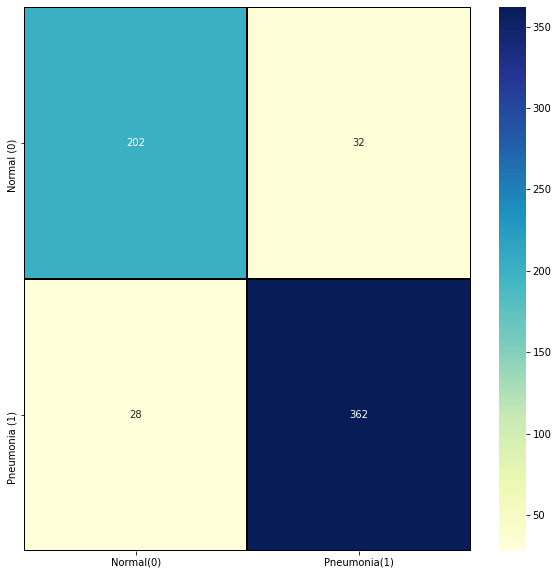

In [213]:
draw_confusion_matrix(model_v1, predictions_v1)

In [71]:
print(classification_report(Y_test, predictions_v1, target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))

                     precision    recall  f1-score   support

   Normal (Class 0)       0.88      0.86      0.87       234
Pneumonia (Class 1)       0.92      0.93      0.92       390

           accuracy                           0.90       624
          macro avg       0.90      0.90      0.90       624
       weighted avg       0.90      0.90      0.90       624



In [177]:
def split_predictions(predictions_vx):
    """
    Split the predictions into correct and incorrect guesses
        
        PARAMETERS:
        predictions_vx (numpy.ndarray): Predictions made by the model
    
    """
    predictions_v1_list = list(map(int,predictions_v1))
    Y_test_list = list(map(int,Y_test))
    merge_lists = list(zip(predictions_v1_list, Y_test_list))
    correct_guesses = []
    incorrect_guesses = []

    for index, i in enumerate(merge_lists):
        if i[0] == i[1]:
            correct_guesses.append([X_test[index],i[1]])
        else:
            incorrect_guesses.append([X_test[index],i[1]])
    
    return(correct_guesses, incorrect_guesses)

In [170]:
def correct_guess_display(correct_guesses):
    """
    Display X-rays of correct guesses
        
        PARAMETERS:
        correct_guesses (list): Image data and label of correct guesses
    
    """
    fig=plt.figure(figsize=(8, 8))
    columns = 2
    rows = 2
    for i in range(1, columns*rows +1):
        index = random.randint(0, len(correct_guesses))
        img = correct_guesses[index][0]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
        plt.axis('off')
        if (correct_guesses[index][1]) == 0:
            plt.title("Actual: Normal"+"\n"+"Prediction: Normal" + "(" + str(correct_guesses[index][1]) + ")")
        else:
            plt.title("Actual: Pneumonia"+"\n"+"Prediction: Pneumonia" + "(" + str(correct_guesses[index][1]) + ")")
    plt.show()

In [174]:
def incorrect_guess_display(incorrect_guesses):
    """
    Display X-rays of incorrect guesses
        
        PARAMETERS:
        incorrect_guesses (list): Image data and label of incorrect guesses
    
    """
    fig=plt.figure(figsize=(8, 8))
    columns = 2
    rows = 2
    for i in range(1, columns*rows +1):
        index = random.randint(0, len(incorrect_guesses))
        img = incorrect_guesses[index][0]
        fig.add_subplot(rows,columns, i)
        plt.imshow(img)
        plt.axis('off')
        if (incorrect_guesses[index][1]) == 0:
            plt.title("Actual: Pneumonia"+"\n"+"Prediction: Normal" + "(" + str(incorrect_guesses[index][1]) + ")")
        else:
            plt.title("Actual: Normal"+"\n"+"Prediction: Pneumonia" + "(" + str(incorrect_guesses[index][1]) + ")")
        

In [181]:
correct_guesses_v1, incorrect_guesses_v1 = split_predictions(predictions_v1)

<h1 style="text-align:center;">Correctly Predicted X-Rays</h1>


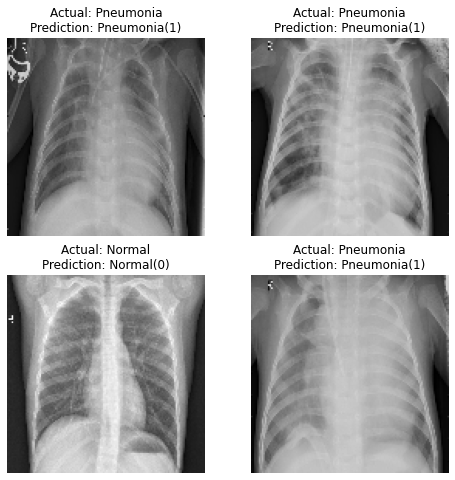

In [182]:
correct_guess_display(correct_guesses)

<h1 style="text-align:center;">Incorrectly Predicted X-Rays</h1>

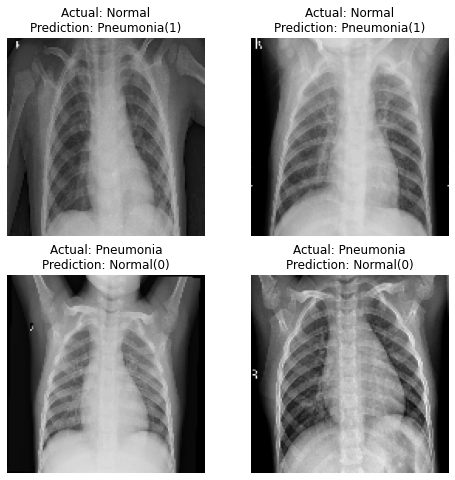

In [183]:
incorrect_guess_display(incorrect_guesses)

<h1 style="font-size:2em;">Model v1 - Short comings </h1>
<p>Although the results from model v1 aren't too bad, we could certainly imporve upon this model.</p>


<p>As mentioned earlier our data is highly skewed and the size of our validation data is very small.</p>

<p>To tackle these issues and imporve our model for v2, we will go ahead and try two new things.</p>

<ul>
  <li>Increase the size of validation data by using some of the training data.</li>
    <br>
  <li>Undersampling will be used to account for the skewed data.</li>
    <br>
</ul>


---

<h1 style="font-size:2em;">Building model v2</h1>

<p>Now we will define and train v2 of our model.</p>
<p>Model v2 will use the new imporvements mentioned above and will follow the same data preprocessing techniques as well as the same Neural Network architecure shown earlier</p>

---

In [76]:
def load_data_limited(input_dir):
    """
    Load enough data (and standardize) so that there are same number of NORMAL and PNEUMONIA images
        
        PARAMETERS:
        input_dir (str): Input directory of the data
        
        RETURN:
        np.asarray(data) (np.ndarray): Image data with labels
    
    """
    data = []
    labels = ["NORMAL", "PNEUMONIA"]
    count = 0
    for i in os.listdir(input_dir):
        if i == "NORMAL":
            for j in os.listdir(input_dir+"/"+i):
                if j != "__MACOSX" and j != ".DS_Store":
                    curr_img = cv2.imread(input_dir+"/"+i+"/"+j)
                    curr_img = cv2.resize(curr_img, (128,128))
                    curr_img = curr_img/curr_img.max()
                    data.append([curr_img, 0])
        elif i == "PNEUMONIA":
            for j in os.listdir(input_dir+"/"+i):
                if j != "__MACOSX" and j != ".DS_Store" and count <= 1342:
                    curr_img = cv2.imread(input_dir+"/"+i+"/"+j)
                    curr_img = cv2.resize(curr_img, (128,128))
                    curr_img = curr_img/curr_img.max()
                    data.append([curr_img, 1])
                    count += 1
                elif count == 1342:
                    break
    return(np.asarray(data))

In [77]:
train_data = load_data_limited(train_dir)

In [78]:
#1342 NORMAL XRAYS
#1342 PNEUMONIA XRAYS
train_data.shape

(2684, 2)

In [79]:
#Taking 50 additional images from the training data as validation data 
additional_val_data = train_data[:50]

In [80]:
val_data = np.vstack((val_data,additional_val_data))

In [81]:
val_data.shape

(116, 2)

In [82]:
X_train, Y_train = split_data(train_data)
X_test, Y_test = split_data(test_data)
X_val, Y_val = split_data(val_data)

In [83]:
batch_size = 32
epochs = 10
validation_data = ImageGenerator.flow(X_val, Y_val)
training_data = ImageGenerator.flow(X_train, Y_train)

<h1 style="font-size:2em;">Training the Model - v2</h1>

<p>Now we will define and train v2 of our model.</p>
<p>This is the same model architechture used in v1</p>
<p>Scroll up for visual diagram</p>

---

In [84]:
model_v2 = Sequential()
model_v2.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (128,128,3)))
model_v2.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model_v2.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_v2.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model_v2.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_v2.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model_v2.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_v2.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model_v2.add(Flatten())

model_v2.add(Dense(units = 128 , activation = 'relu'))

model_v2.add(Dropout(0.2))

model_v2.add(Dense(units = 1 , activation = 'sigmoid'))

model_v2.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])

model_v2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 256)      

In [85]:
results_v2 = model_v2.fit(training_data, epochs=epochs, validation_data=validation_data)

Epoch 1/10
84/84 [==============================] - 62s 740ms/step - loss: 0.6706 - accuracy: 0.6103 - val_loss: 0.5428 - val_accuracy: 0.7328
Epoch 2/10
84/84 [==============================] - 67s 802ms/step - loss: 0.5508 - accuracy: 0.7403 - val_loss: 0.4049 - val_accuracy: 0.8017
Epoch 3/10
84/84 [==============================] - 73s 873ms/step - loss: 0.4446 - accuracy: 0.8059 - val_loss: 0.3552 - val_accuracy: 0.8534
Epoch 4/10
84/84 [==============================] - 65s 779ms/step - loss: 0.3173 - accuracy: 0.8715 - val_loss: 0.2428 - val_accuracy: 0.9310
Epoch 5/10
84/84 [==============================] - 65s 770ms/step - loss: 0.2853 - accuracy: 0.8811 - val_loss: 0.4672 - val_accuracy: 0.7759
Epoch 6/10
84/84 [==============================] - 65s 773ms/step - loss: 0.2627 - accuracy: 0.8931 - val_loss: 0.3310 - val_accuracy: 0.9052
Epoch 7/10
84/84 [==============================] - 64s 768ms/step - loss: 0.2512 - accuracy: 0.8983 - val_loss: 0.3014 - val_accuracy: 0.8707

In [ ]:
#model.save("PneumoniaNNv2_NEW.h5")

In [97]:
model_v2 = load_model("PneumoniaNNv2_NEW.h5")

In [98]:
test_results_v2 = model_v2.evaluate(X_test,Y_test)
print("Test data accuracy: " + str(test_results_v2[1]*100))
print("Test data loss: " + str(test_results_v2[0]*100))

20/20 [==============================] - 3s 136ms/step - loss: 0.3061 - accuracy: 0.9167
Test data accuracy: 91.66666865348816
Test data loss: 30.609413981437683


In [220]:
accuracy_graphs(results_v2)
loss_graphs(results_v2)

In [53]:
predictions_v2 = model_v2.predict_classes(X_test)

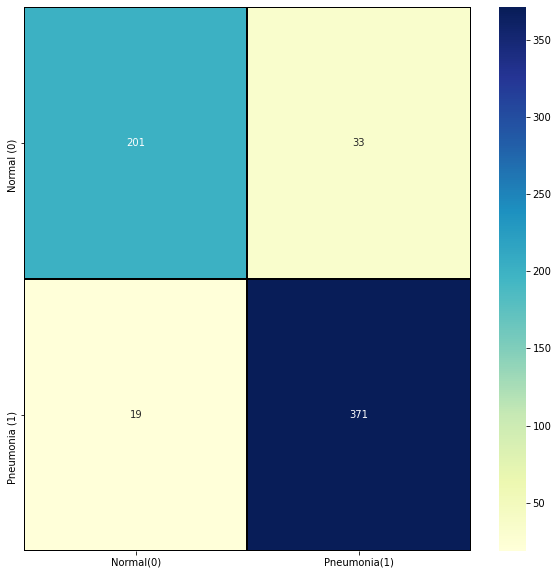

In [54]:
draw_confusion_matrix(model_v2, predictions_v2)

In [69]:
print(classification_report(Y_test, predictions_v2, target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))

                     precision    recall  f1-score   support

   Normal (Class 0)       0.91      0.86      0.89       234
Pneumonia (Class 1)       0.92      0.95      0.93       390

           accuracy                           0.92       624
          macro avg       0.92      0.91      0.91       624
       weighted avg       0.92      0.92      0.92       624



In [184]:
correct_guesses_v2, incorrect_guesses_v2 = split_predictions(predictions_v2)

<h1 style="text-align:center;">Correctly Predicted X-Rays</h1>


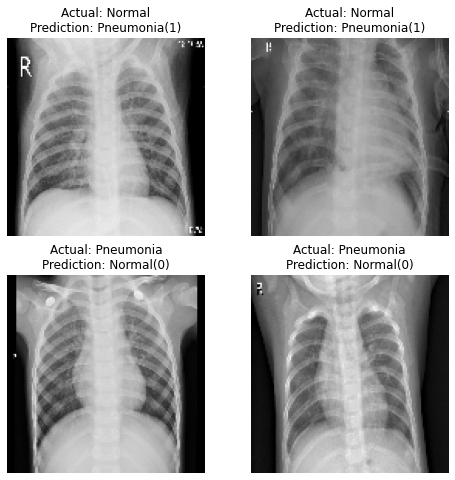

In [186]:
incorrect_guess_display(incorrect_guesses_v2)

<h1 style="text-align:center;">Correctly Predicted X-Rays</h1>


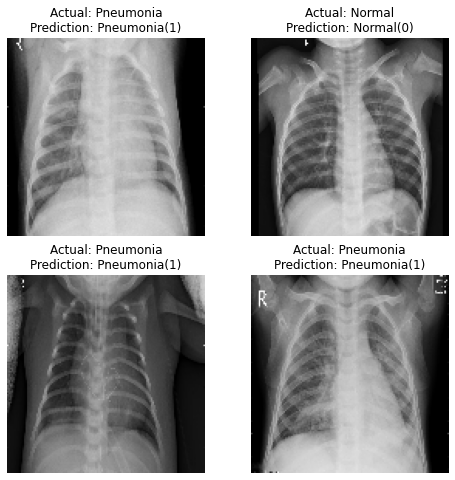

In [185]:
correct_guess_display(correct_guesses_v2)

<h1 style="font-size:2em;">Model v2 - Short comings </h1>
<p>Albeit a small improvement, v2 is still an overall success and is better than the one before.</p>


<p>Having tackled the initial issues of the skewed data set and small validation sample, model v2 achieved an overall accuraccy of 92%. Not Bad.</p>

<p>Despite overcoming the problems with v1, v2 is no where perfect. Some of it's most prominent issues are:</p>

<ul>
  <li>Small training data. Only 1342 X-ray images.</li>
    <br>
  <li>X-ray data is not diverse.</li>
    <br>
  <li>Pneumonia is particularly small and difficult to detect</li>
</ul>


---

<h1 style="font-size:2em;">Outro</h1>


<p>Connect with me:</p>

<ul>
    <li><a href = https://github.com/Zafirmk>Github</a></li>
    <br>
    <li><a href = https://www.linkedin.com/in/zafirmk/>LinkedIn</a></li>
    <br>
</ul>